In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import recall_score, f1_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# df = # Load metadata
metadata_path = "/kaggle/input/patches300/patches300/patches_labels.csv"
metadata = pd.read_csv(metadata_path)
print("Metadata sample:")
display(metadata)

Metadata sample:


,patch_name,original_image,label,target
0,006388_0_patch_0.png,006388_0.tif,CE,1
1,006388_0_patch_1.png,006388_0.tif,CE,1
2,006388_0_patch_2.png,006388_0.tif,CE,1
3,006388_0_patch_3.png,006388_0.tif,CE,1
4,006388_0_patch_4.png,006388_0.tif,CE,1
...,...,...,...,...
68866,ffec5c_1_patch_86.png,ffec5c_1.tif,LAA,0
68867,ffec5c_1_patch_87.png,ffec5c_1.tif,LAA,0
68868,ffec5c_1_patch_88.png,ffec5c_1.tif,LAA,0
68869,ffec5c_1_patch_89.png,ffec5c_1.tif,LAA,0


In [4]:
# Assuming your DataFrame is named df
metadata['path'] = "/kaggle/input/patches300/patches300/patches300/" + metadata['patch_name']

# Now, keep only the 'label' and 'path' columns
df = metadata[['label', 'path']]
df

,label,path
0,CE,/kaggle/input/patches300/patches300/patches300...
1,CE,/kaggle/input/patches300/patches300/patches300...
2,CE,/kaggle/input/patches300/patches300/patches300...
3,CE,/kaggle/input/patches300/patches300/patches300...
4,CE,/kaggle/input/patches300/patches300/patches300...
...,...,...
68866,LAA,/kaggle/input/patches300/patches300/patches300...
68867,LAA,/kaggle/input/patches300/patches300/patches300...
68868,LAA,/kaggle/input/patches300/patches300/patches300...
68869,LAA,/kaggle/input/patches300/patches300/patches300...


In [5]:
label_encoder = LabelEncoder()
df.loc[:, 'label_encoded'] = label_encoder.fit_transform(df['label'], )
# Drop the old 'label' column
df = df.drop("label", axis=1)

# Rename the 'label_encoded' column to 'label'
df = df.rename(columns={"label_encoded": "label"})
df

<ipython-input-5-50f57f82af88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'label_encoded'] = label_encoder.fit_transform(df['label'], )


,path,label
0,/kaggle/input/patches300/patches300/patches300...,0
1,/kaggle/input/patches300/patches300/patches300...,0
2,/kaggle/input/patches300/patches300/patches300...,0
3,/kaggle/input/patches300/patches300/patches300...,0
4,/kaggle/input/patches300/patches300/patches300...,0
...,...,...
68866,/kaggle/input/patches300/patches300/patches300...,1
68867,/kaggle/input/patches300/patches300/patches300...,1
68868,/kaggle/input/patches300/patches300/patches300...,1
68869,/kaggle/input/patches300/patches300/patches300...,1


In [6]:
# import torch
# from torch import nn
# from torchvision import models

# # Define the model architecture
# def create_model():
#     # Load pre-trained MobileNetV3-Large
#     model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
    
#     # Modify the classifier for binary classification
#     model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, 2)
    
#     return model

# # Load model weights from a .pth file
# def load_model(model, model_path):
#     # Load the state_dict from the .pth file
#     state_dict = torch.load(model_path, weights_only=True)  # Explicitly set weights_only=True
#     model.load_state_dict(state_dict)
#     model.eval()  # Set the model to evaluation mode
#     return model

# # Initialize the model
# model = create_model()

# # Path to your saved model .pth file
# model_path = '/kaggle/input/backgroundclassifier/pytorch/default/1/best_model.pth'  # Replace with your actual .pth file path

# # Load the weights into the model
# model = load_model(model, model_path)

# # Check if the model is loaded successfully
# model


In [7]:
# from tqdm import tqdm

# # Function to classify images with tqdm progress bar
# def classify_images(model, image_paths, transform, device):
#     model.to(device)
    
#     # Placeholder for keeping non-empty images
#     valid_images = []
    
#     # Wrap image_paths with tqdm for the progress bar
#     for image_path in tqdm(image_paths, desc="Classifying images", unit="image"):
#         # Load the image
#         image = Image.open(image_path).convert('RGB')
#         image = transform(image).unsqueeze(0)  # Add batch dimension (1, C, H, W)
#         image = image.to(device)

#         # Predict the class (empty or not)
#         with torch.no_grad():
#             output = model(image)
#             _, predicted = torch.max(output, 1)  # 0 = empty, 1 = not empty
            
#             # If predicted label is 1 (not empty), keep this image
#             if predicted.item() == 1:
#                 valid_images.append(image_path)
    
#     return valid_images

# # Define your transformation (resize, normalize)
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Adjust for your model
# ])

# image_paths = df["path"].tolist()  
# labels = df["label"].tolist()   


# # Classify images and filter out empty images
# valid_images = classify_images(model, image_paths, transform, device)

In [8]:
df_valid_path = "/kaggle/input/new-dataset-after-background-removal/valid_images.csv"
df_valid = pd.read_csv(df_valid_path)

df_invalid_path = "/kaggle/input/new-dataset-after-background-removal/invalid_images.csv"
df_invalid = pd.read_csv(df_invalid_path)

In [9]:
# Update  dataset to remove empty images (if you also have labels or other metadata)
# df_valid = df[df['path'].isin(valid_images)]  # This will update your dataframe to exclude empty images
df_valid

,path,label
0,/kaggle/input/patches300/patches300/patches300...,0
1,/kaggle/input/patches300/patches300/patches300...,0
2,/kaggle/input/patches300/patches300/patches300...,0
3,/kaggle/input/patches300/patches300/patches300...,0
4,/kaggle/input/patches300/patches300/patches300...,0
...,...,...
26462,/kaggle/input/patches300/patches300/patches300...,1
26463,/kaggle/input/patches300/patches300/patches300...,1
26464,/kaggle/input/patches300/patches300/patches300...,1
26465,/kaggle/input/patches300/patches300/patches300...,1


In [10]:
# DataFrame with paths not in valid_images (empty images)
# df_invalid = df[~df['path'].isin(valid_images)].reset_index(drop=True)
df_invalid

,path,label
0,/kaggle/input/patches300/patches300/patches300...,0
1,/kaggle/input/patches300/patches300/patches300...,0
2,/kaggle/input/patches300/patches300/patches300...,0
3,/kaggle/input/patches300/patches300/patches300...,0
4,/kaggle/input/patches300/patches300/patches300...,0
...,...,...
42399,/kaggle/input/patches300/patches300/patches300...,1
42400,/kaggle/input/patches300/patches300/patches300...,1
42401,/kaggle/input/patches300/patches300/patches300...,1
42402,/kaggle/input/patches300/patches300/patches300...,1


In [11]:
# # Save valid and invalid DataFrames as CSV files
# df_valid.to_csv("valid_images.csv", index=False)
# df_invalid.to_csv("invalid_images.csv", index=False)

# # Check if the files are saved correctly
# print("Files saved: valid_images.csv and invalid_images.csv")

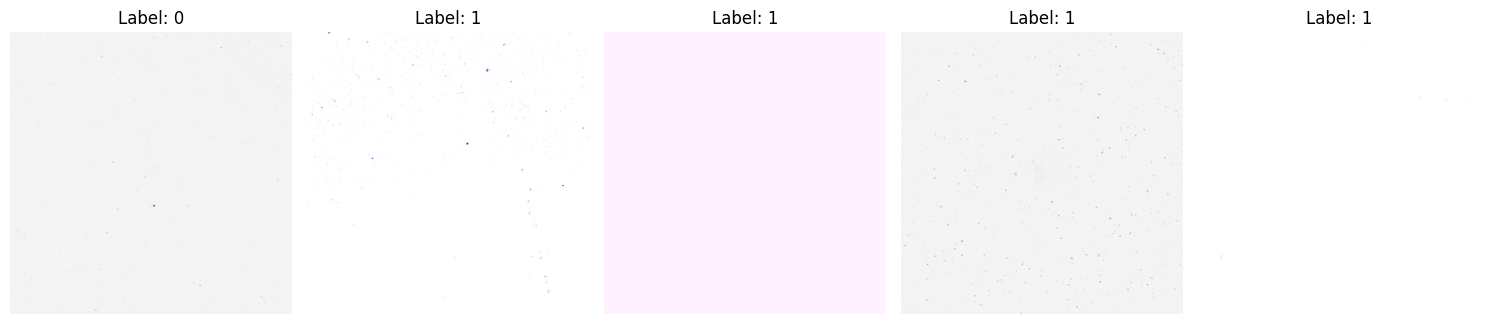

In [12]:
# Function to plot random samples with labels
def plot_random_samples(df, num_samples=5):
    # Randomly sample 'num_samples' rows from the dataframe
    sampled_df = df.sample(n=num_samples)

    # Set up the plot grid (e.g., 1 row, num_samples columns)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    # Loop through the sampled images and display them
    for i, (index, row) in enumerate(sampled_df.iterrows()):
        image_path = row['path']
        label = row['label']
        
        # Load and display the image
        image = Image.open(image_path).convert('RGB')
        axes[i].imshow(image)
        axes[i].axis('off')  # Hide axis
        
        # Set title with label
        axes[i].set_title(f"Label: {label}")

    plt.tight_layout()
    plt.show()

plot_random_samples(df_invalid, num_samples=5)  

In [13]:
class CellularImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [14]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Define Albumentations augmentation pipeline for training
train_augmentation_pipeline = A.Compose([
    A.Resize(256, 256),                  # Resize all images to 256x256
    A.HorizontalFlip(p=0.5),             # 50% chance of horizontal flip
    A.VerticalFlip(p=0.5),               # 50% chance of vertical flip
    A.RandomRotate90(p=0.5),             # 50% chance of 90-degree rotation
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
    ToTensorV2()  # Convert to PyTorch tensor
])

# Define Albumentations pipeline for validation and testing (no augmentation, only resizing and normalization)
val_test_augmentation_pipeline = A.Compose([
    A.Resize(256, 256),                  # Resize all images to 256x256
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize using ImageNet stats
    ToTensorV2()  # Convert to PyTorch tensor
])

# Define Dataset class
class CellularImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

        # Apply augmentation/transformations
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        # Get label
        label = self.labels[idx]

        return image, label

# Split the dataset
image_paths = df_valid["path"].tolist()  
labels = df_valid["label"].tolist()

train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=0.25, random_state=42)

# Create datasets
train_dataset = CellularImageDataset(train_paths, train_labels, transform=train_augmentation_pipeline)
val_dataset = CellularImageDataset(val_paths, val_labels, transform=val_test_augmentation_pipeline)
test_dataset = CellularImageDataset(test_paths, test_labels, transform=val_test_augmentation_pipeline)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Test the DataLoaders
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Example of iterating through the training DataLoader
for images, labels in tqdm(train_loader, desc="Loading training batches"):
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {len(labels)}")
    break


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Train dataset size: 15879
Validation dataset size: 5294
Test dataset size: 5294


Loading training batches:   0%|          | 0/249 [00:01<?, ?it/s]

Batch images shape: torch.Size([64, 3, 256, 256])
Batch labels shape: 64


In [15]:
for images, labels in train_loader:
    print("Train loader:")
    print(f"Image batch shape: {images.shape}")
    print(f"Labels batch shape: {labels.shape}")
    break  # Only print for the first batch, to avoid printing too much

Train loader:
Image batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: torch.Size([64])


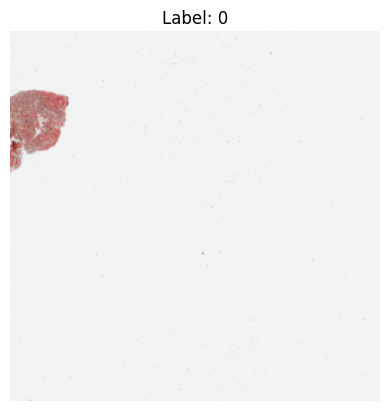

In [16]:
# Function to denormalize and convert tensor to image
def denormalize(tensor, mean, std):
    """Denormalize a tensor image."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Get a sample from the train_loader (you can also use val_loader or test_loader)
for images, labels in train_loader:
    image = images[0]  # Get the first image in the batch
    label = labels[0]  # Get the first label in the batch

    # Denormalize the image (if necessary, otherwise you can skip this step)
    image = denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Convert tensor to numpy array for plotting
    image = image.numpy().transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

    # Plot the image
    plt.imshow(image)
    plt.title(f"Label: {label.item()}")  # Display label (assuming it's a single label)
    plt.axis('off')  # Hide axes
    plt.show()

    break  # Display only the first sample; remove break to display for more images


In [17]:
# Count the occurrences of each class
class_counts = df_valid['label'].value_counts()

# Total number of samples
total_samples = len(df_valid)

# Calculate weights as inverse frequency
class_weights = total_samples / class_counts

# Convert to a PyTorch tensor
class_weights_tensor = torch.tensor(class_weights.values, dtype=torch.float32)

# Map weights to class indices
class_to_weight = dict(zip(class_counts.index, class_weights))
print("Class Weights Mapping:", class_to_weight)
print("PyTorch Class Weights Tensor:", class_weights_tensor)

Class Weights Mapping: {0: 1.4867430625772384, 1: 3.0544720138488173}
PyTorch Class Weights Tensor: tensor([1.4867, 3.0545])


In [18]:
import torch
import torch.nn as nn
from timm import create_model

def create_optimized_poolformer36_model(num_classes=2, dropout_rate=0.5, trainable_backbone_layers=2):
    """
    Creates a Poolformer model with improvements for better performance and reduced overfitting.

    Args:
        num_classes (int): Number of output classes.
        dropout_rate (float): Dropout rate for the classifier head.
        trainable_backbone_layers (int): Number of trainable backbone layers from the end.
        use_label_smoothing (bool): Whether to apply label smoothing.

    Returns:
        nn.Module: Optimized Poolformer model ready for fine-tuning.
    """
    # Create the base Poolformer model
    model = create_model('poolformer_s36', pretrained=True)
    
    # Freeze all layers by default
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the last `trainable_backbone_layers` stages in the backbone
    if hasattr(model, "stages"):
        for stage in model.stages[-trainable_backbone_layers:]:
            for param in stage.parameters():
                param.requires_grad = True
    else:
        raise AttributeError("The Poolformer model does not have the expected 'stages' attribute.")

    # Modify the classifier head
    if hasattr(model.head, "fc"):  # Access the fully connected layer in the head
        in_features = model.head.fc.in_features
        model.head.fc = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features, in_features // 2),  # Intermediate dense layer
            nn.ReLU(),
            nn.BatchNorm1d(in_features // 2),
            nn.Dropout(p=dropout_rate),
            nn.Linear(in_features // 2, num_classes)
        )
    else:
        raise AttributeError("The Poolformer model does not have the expected 'fc' in the head.")

    # Ensure classifier head is trainable
    for param in model.head.parameters():
        param.requires_grad = True


    return model

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_classes = 2
dropout_rate = 0.4  # Increased dropout rate to reduce overfitting
trainable_backbone_layers = 12  # Fine-tune more layers in the backbone

# Create the optimized model
model = create_optimized_poolformer36_model(
    num_classes=num_classes, 
    dropout_rate=dropout_rate, 
    trainable_backbone_layers=trainable_backbone_layers,
).to(device)


model.safetensors:   0%|          | 0.00/123M [00:00<?, ?B/s]

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Starting training on device: cuda


Training:   0%|          | 0/249 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training: 100%|██████████| 249/249 [07:13<00:00,  1.74s/it]



Epoch 1/20 - Time: 518.98s
Train: loss: 1.3836 accuracy: 0.5997 precision: 0.5883 recall: 0.5997 f1: 0.5824
Val: loss: 1.2964 accuracy: 0.6083 precision: 0.6461 recall: 0.6083 f1: 0.6122
Best loss: 1.2964


Training: 100%|██████████| 249/249 [05:18<00:00,  1.28s/it]



Epoch 2/20 - Time: 364.59s
Train: loss: 1.2550 accuracy: 0.6532 precision: 0.6353 recall: 0.6532 f1: 0.6290
Val: loss: 1.2658 accuracy: 0.6455 precision: 0.6835 recall: 0.6455 f1: 0.6535
Best loss: 1.2658


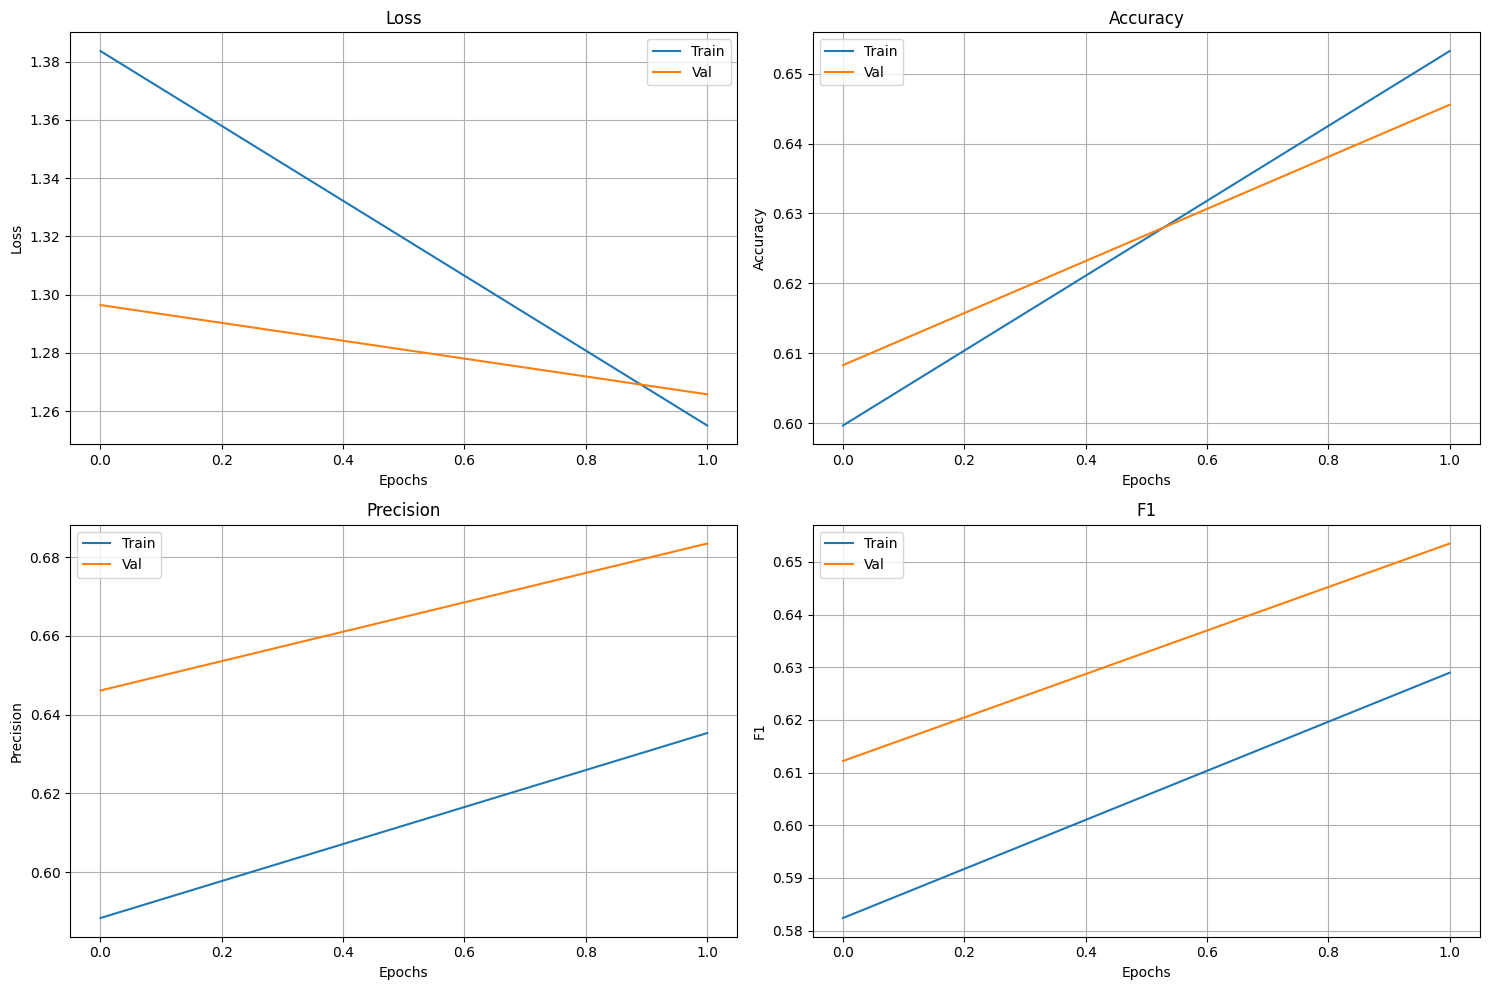

Training: 100%|██████████| 249/249 [05:13<00:00,  1.26s/it]



Epoch 3/20 - Time: 358.21s
Train: loss: 1.1493 accuracy: 0.6911 precision: 0.6703 recall: 0.6911 f1: 0.6699
Val: loss: 1.1039 accuracy: 0.7089 precision: 0.6868 recall: 0.7089 f1: 0.6867
Best loss: 1.1039


Training: 100%|██████████| 249/249 [05:10<00:00,  1.25s/it]



Epoch 4/20 - Time: 353.68s
Train: loss: 1.0542 accuracy: 0.7317 precision: 0.7086 recall: 0.7317 f1: 0.7119
Val: loss: 1.0571 accuracy: 0.7393 precision: 0.7202 recall: 0.7393 f1: 0.7253
Best loss: 1.0571


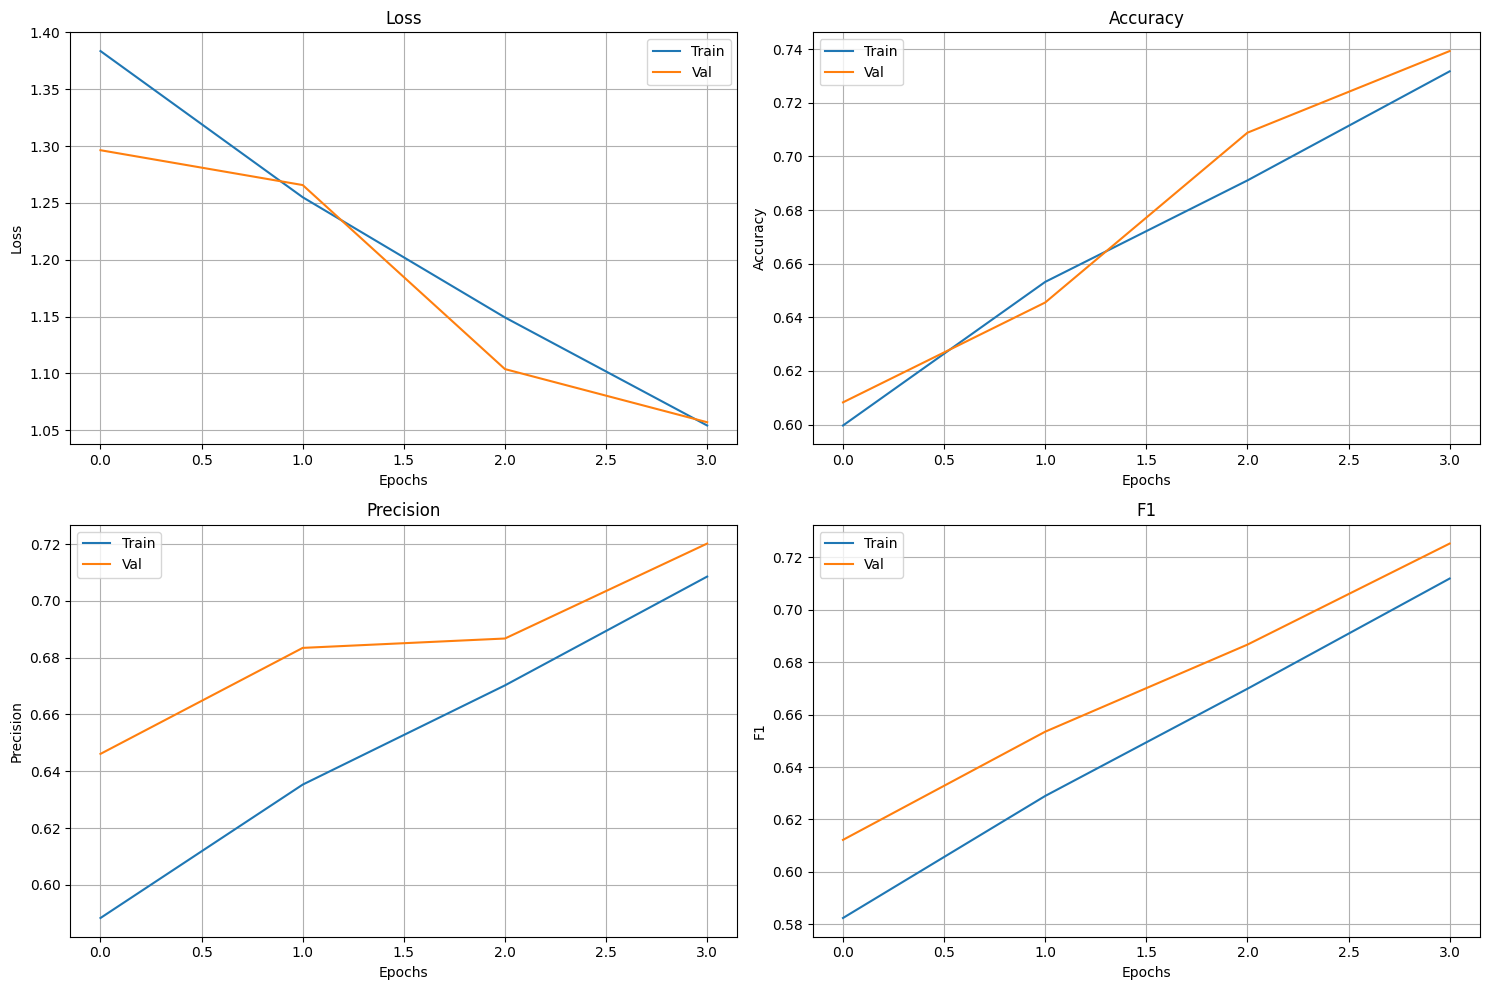

Training: 100%|██████████| 249/249 [05:12<00:00,  1.25s/it]



Epoch 5/20 - Time: 355.58s
Train: loss: 0.9861 accuracy: 0.7504 precision: 0.7278 recall: 0.7504 f1: 0.7330
Val: loss: 0.9383 accuracy: 0.7695 precision: 0.7519 recall: 0.7695 f1: 0.7579
Best loss: 0.9383


Training: 100%|██████████| 249/249 [05:11<00:00,  1.25s/it]



Epoch 6/20 - Time: 356.47s
Train: loss: 0.9112 accuracy: 0.7806 precision: 0.7588 recall: 0.7806 f1: 0.7656
Val: loss: 0.9537 accuracy: 0.7720 precision: 0.7567 recall: 0.7720 f1: 0.7625


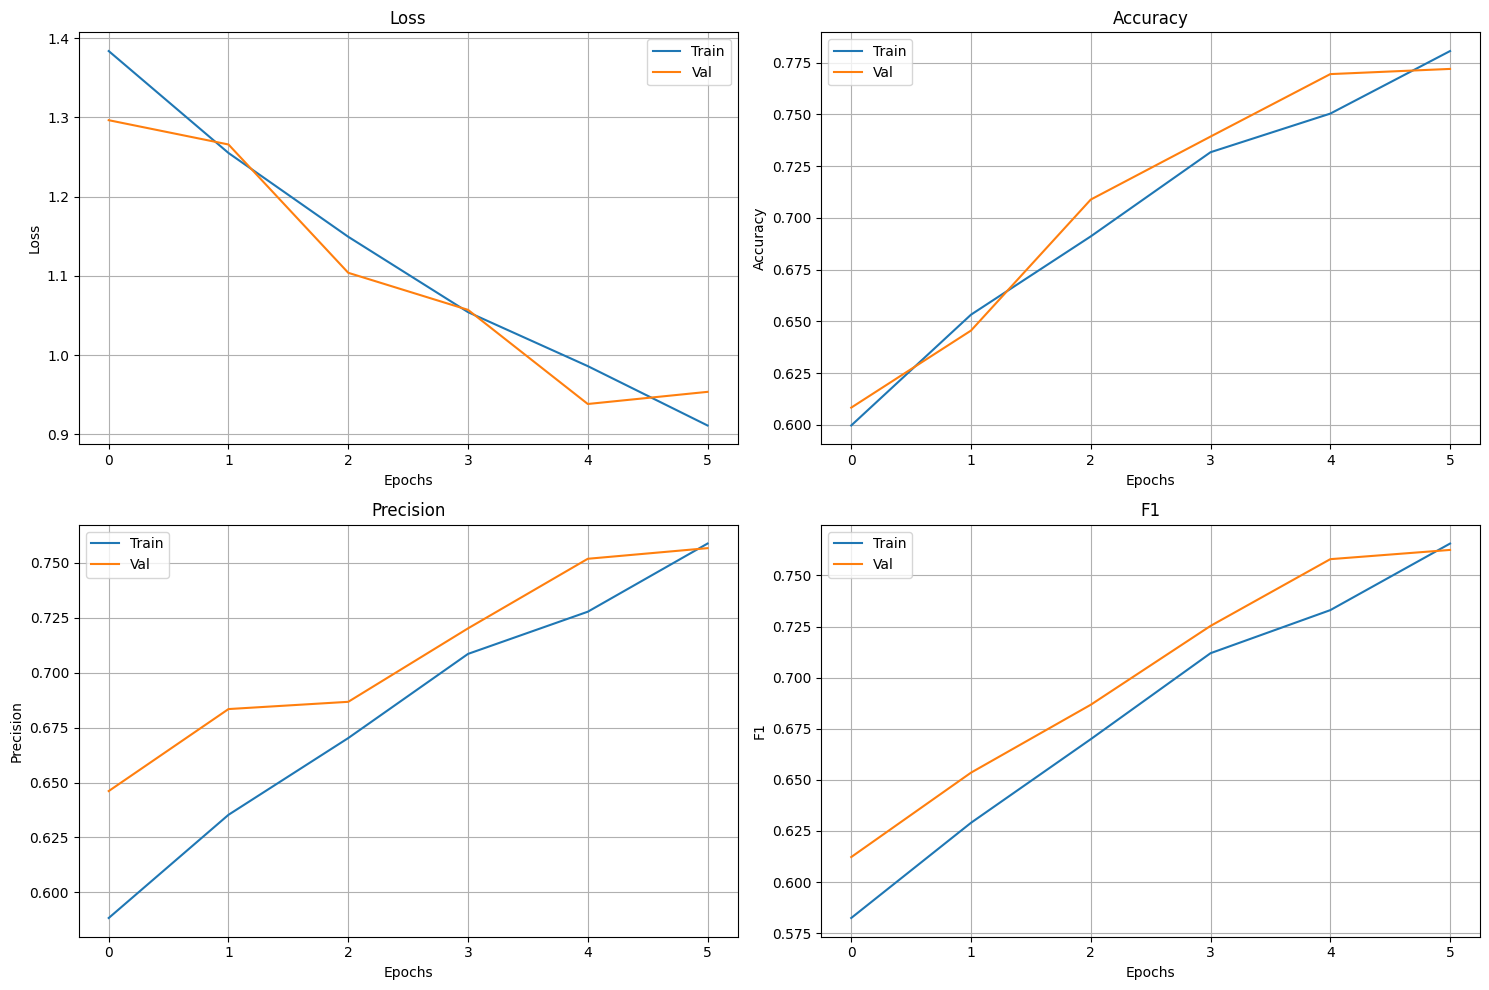

Training: 100%|██████████| 249/249 [05:21<00:00,  1.29s/it]



Epoch 7/20 - Time: 366.05s
Train: loss: 0.8389 accuracy: 0.8017 precision: 0.7781 recall: 0.8017 f1: 0.7855
Val: loss: 0.9185 accuracy: 0.7782 precision: 0.7826 recall: 0.7782 f1: 0.7803
Best loss: 0.9185


Training: 100%|██████████| 249/249 [05:35<00:00,  1.35s/it]



Epoch 8/20 - Time: 380.39s
Train: loss: 0.7636 accuracy: 0.8232 precision: 0.8012 recall: 0.8232 f1: 0.8091
Val: loss: 0.9319 accuracy: 0.7788 precision: 0.7577 recall: 0.7788 f1: 0.7642


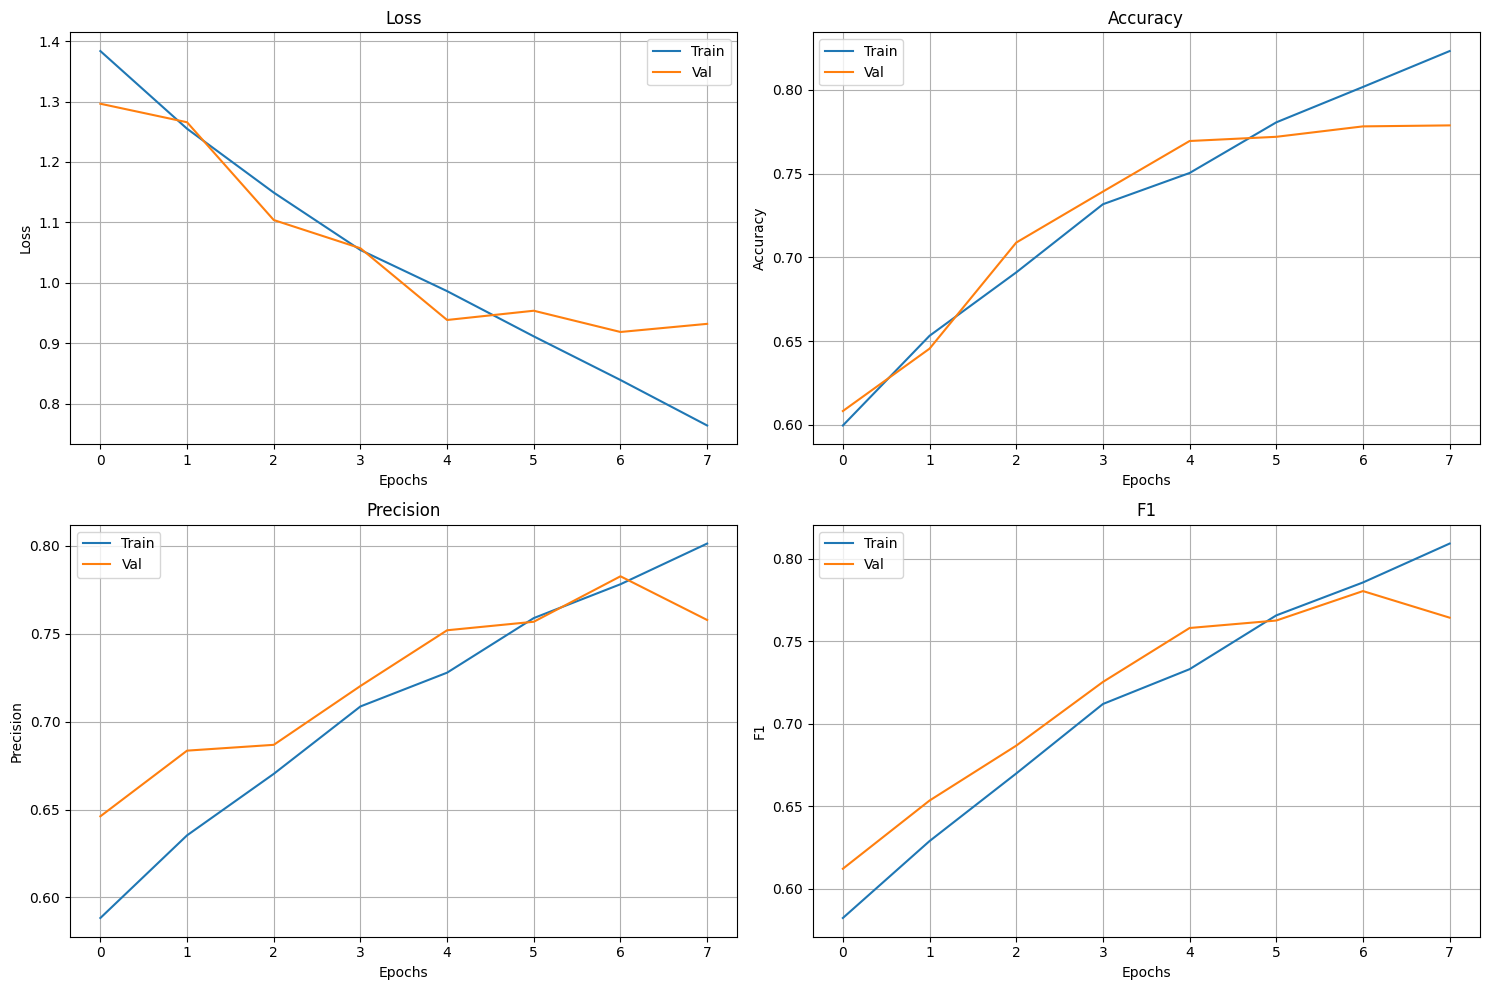

Training: 100%|██████████| 249/249 [05:26<00:00,  1.31s/it]



Epoch 9/20 - Time: 382.73s
Train: loss: 0.7102 accuracy: 0.8410 precision: 0.8199 recall: 0.8410 f1: 0.8279
Val: loss: 0.8577 accuracy: 0.8117 precision: 0.7846 recall: 0.8117 f1: 0.7918
Best loss: 0.8577


Training: 100%|██████████| 249/249 [05:12<00:00,  1.25s/it]



Epoch 10/20 - Time: 357.26s
Train: loss: 0.6395 accuracy: 0.8568 precision: 0.8357 recall: 0.8568 f1: 0.8439
Val: loss: 0.8464 accuracy: 0.8193 precision: 0.7845 recall: 0.8193 f1: 0.7867
Best loss: 0.8464


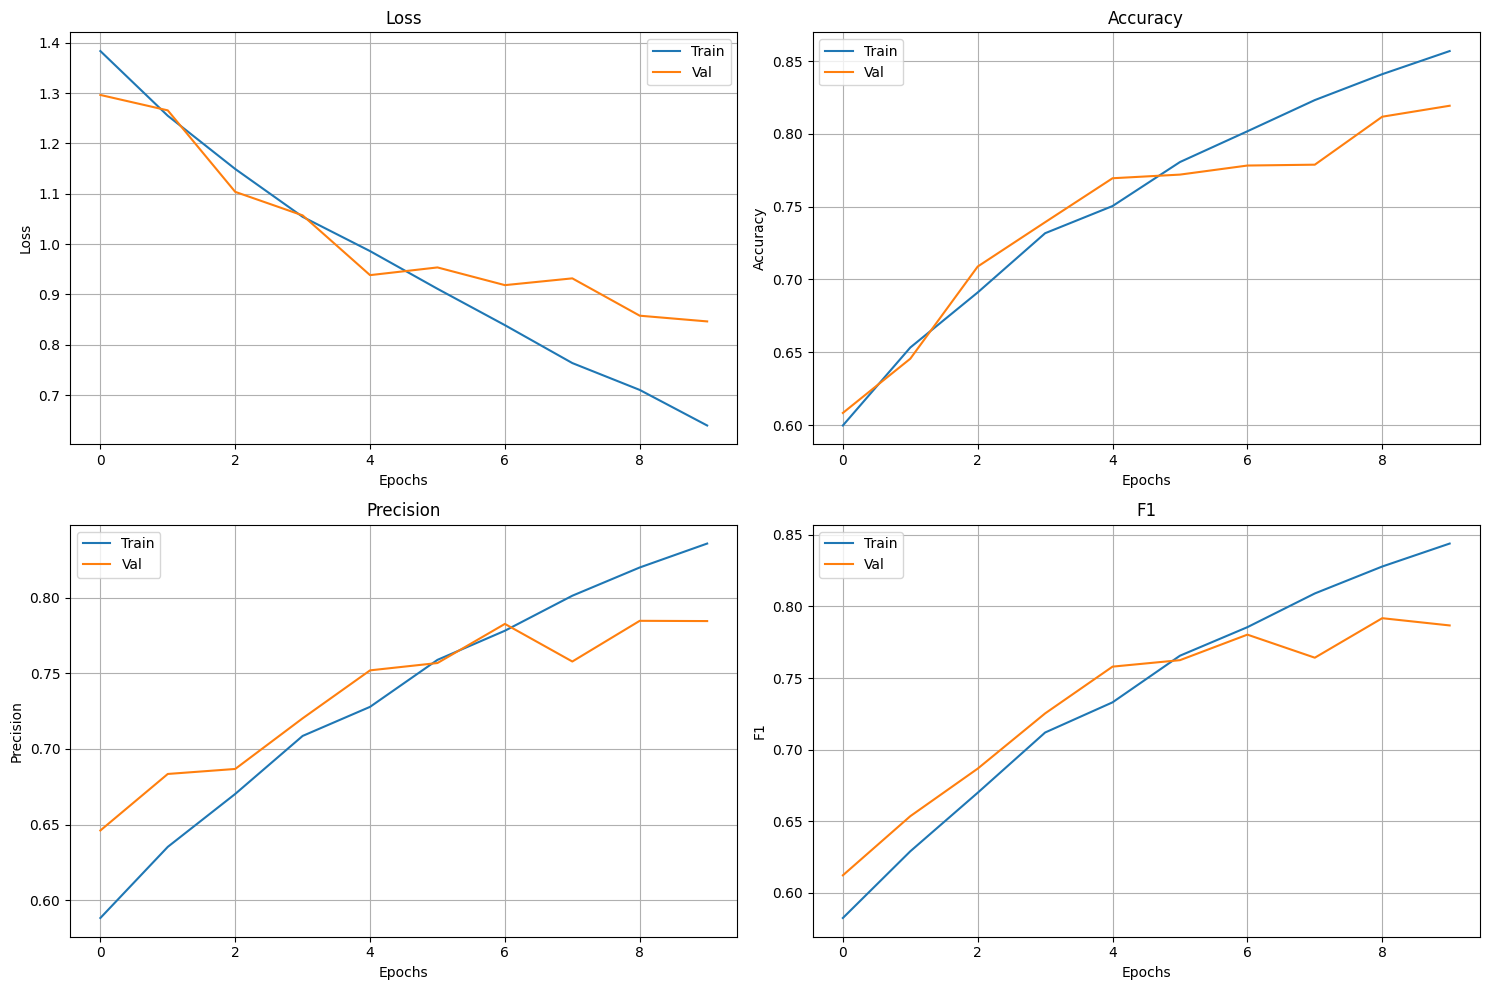

Training: 100%|██████████| 249/249 [05:07<00:00,  1.24s/it]



Epoch 11/20 - Time: 351.60s
Train: loss: 0.5936 accuracy: 0.8705 precision: 0.8521 recall: 0.8705 f1: 0.8597
Val: loss: 0.7490 accuracy: 0.8288 precision: 0.8138 recall: 0.8288 f1: 0.8200
Best loss: 0.7490


Training: 100%|██████████| 249/249 [05:13<00:00,  1.26s/it]



Epoch 12/20 - Time: 356.58s
Train: loss: 0.5355 accuracy: 0.8847 precision: 0.8681 recall: 0.8847 f1: 0.8752
Val: loss: 0.7308 accuracy: 0.8364 precision: 0.8096 recall: 0.8364 f1: 0.8178
Best loss: 0.7308


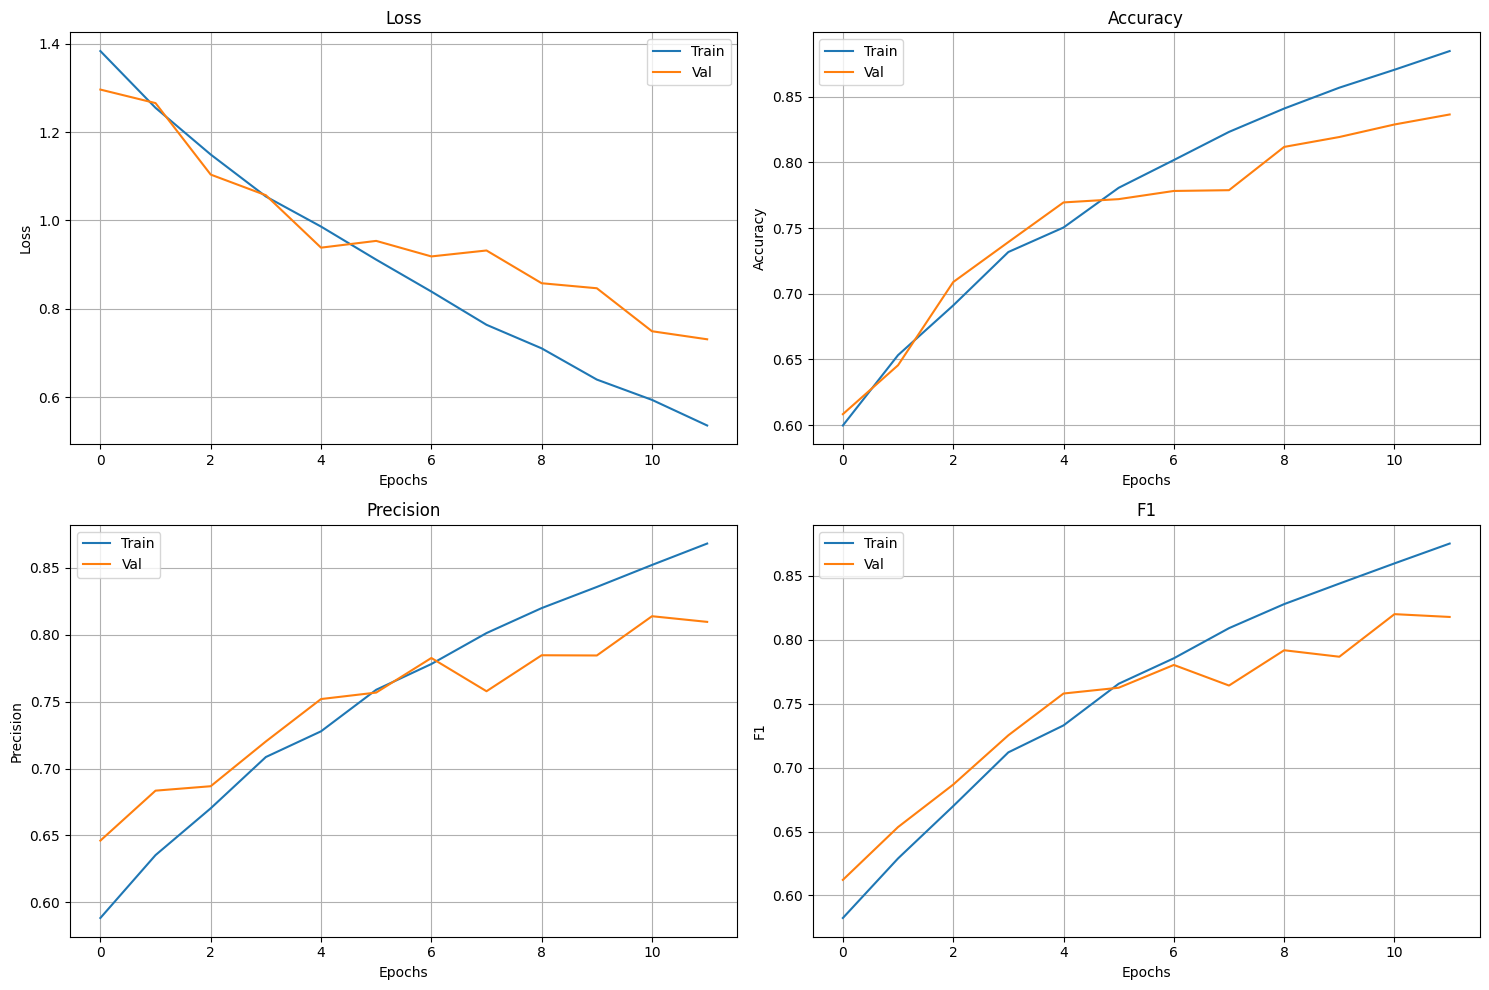

Training: 100%|██████████| 249/249 [05:14<00:00,  1.26s/it]



Epoch 13/20 - Time: 358.59s
Train: loss: 0.4956 accuracy: 0.8957 precision: 0.8762 recall: 0.8957 f1: 0.8844
Val: loss: 0.7726 accuracy: 0.8390 precision: 0.8353 recall: 0.8390 f1: 0.8371


Training: 100%|██████████| 249/249 [05:23<00:00,  1.30s/it]



Epoch 14/20 - Time: 369.76s
Train: loss: 0.4556 accuracy: 0.9042 precision: 0.8909 recall: 0.9042 f1: 0.8969
Val: loss: 0.9405 accuracy: 0.8177 precision: 0.8326 recall: 0.8177 f1: 0.8242


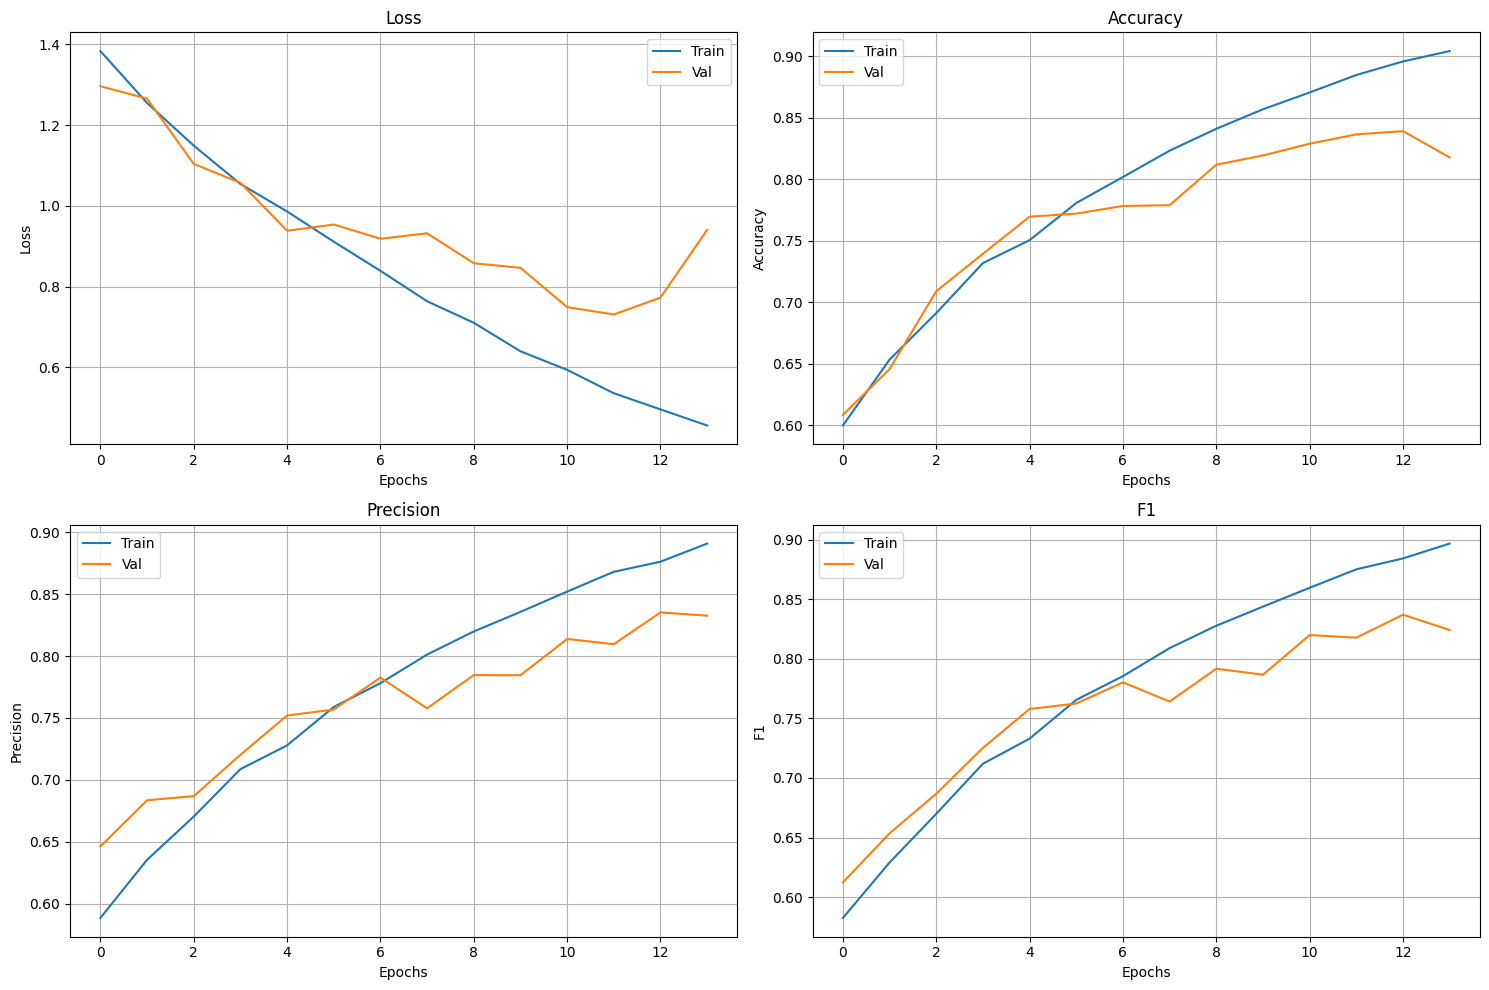

Training: 100%|██████████| 249/249 [05:19<00:00,  1.28s/it]



Epoch 15/20 - Time: 366.36s
Train: loss: 0.4274 accuracy: 0.9117 precision: 0.8969 recall: 0.9117 f1: 0.9035
Val: loss: 0.8392 accuracy: 0.8352 precision: 0.8342 recall: 0.8352 f1: 0.8347


Training: 100%|██████████| 249/249 [05:13<00:00,  1.26s/it]



Epoch 16/20 - Time: 356.73s
Train: loss: 0.2932 accuracy: 0.9418 precision: 0.9327 recall: 0.9418 f1: 0.9370
Val: loss: 0.7794 accuracy: 0.8602 precision: 0.8497 recall: 0.8602 f1: 0.8544


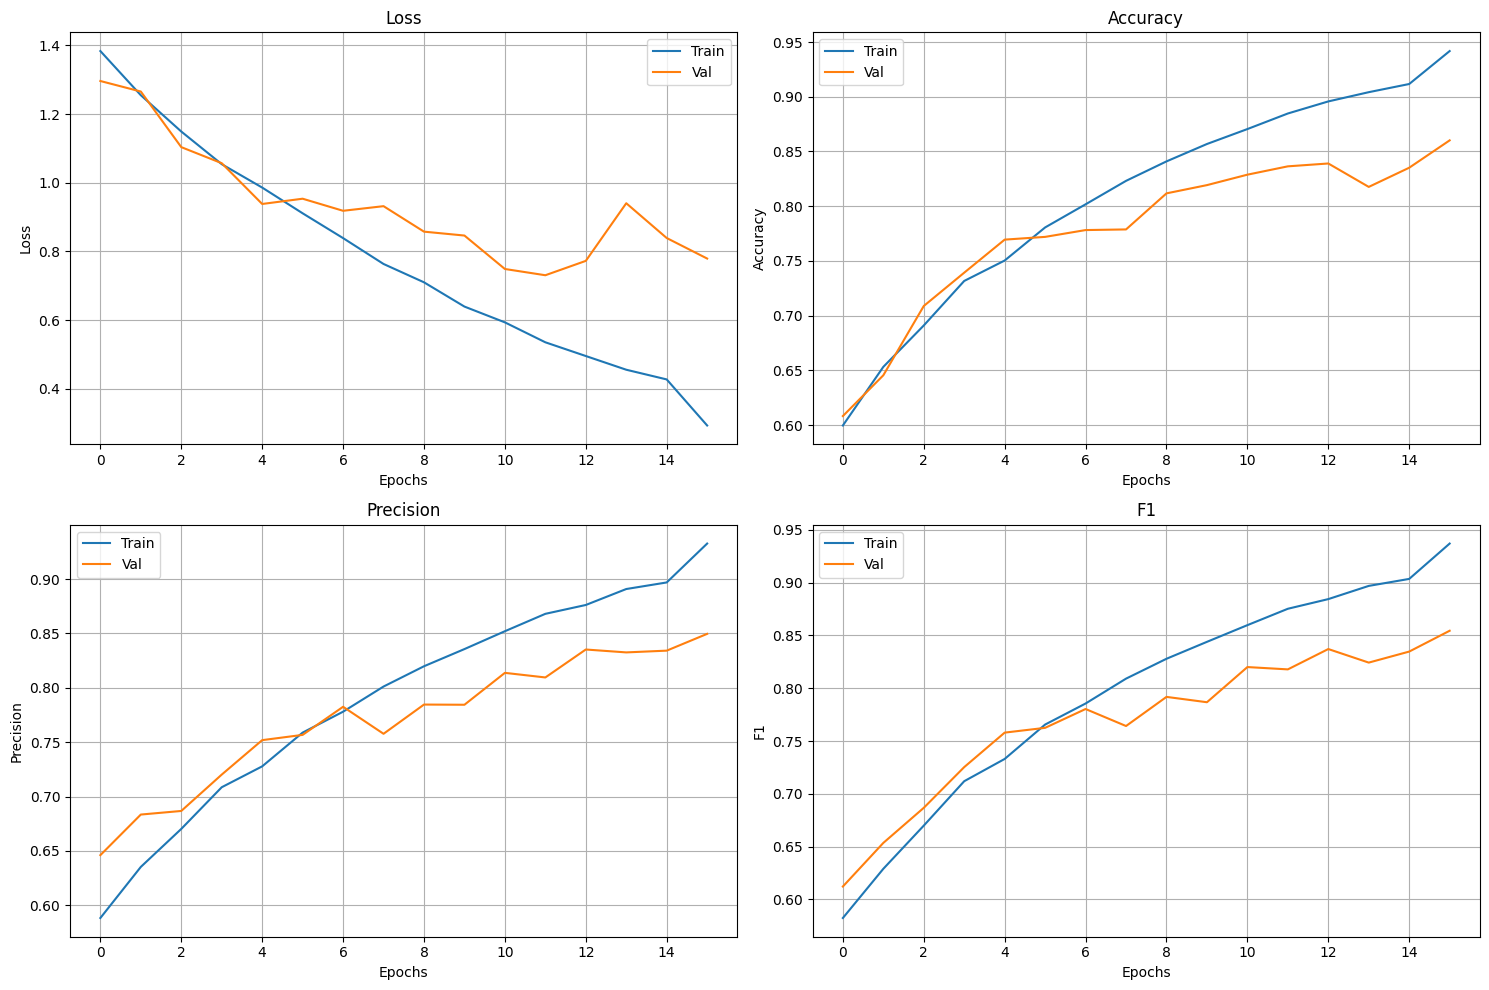

Training: 100%|██████████| 249/249 [05:04<00:00,  1.22s/it]



Epoch 17/20 - Time: 347.46s
Train: loss: 0.2680 accuracy: 0.9480 precision: 0.9401 recall: 0.9480 f1: 0.9438
Val: loss: 0.8898 accuracy: 0.8389 precision: 0.8631 recall: 0.8389 f1: 0.8491
Early stopping at epoch 17

Training completed in 6317.76s


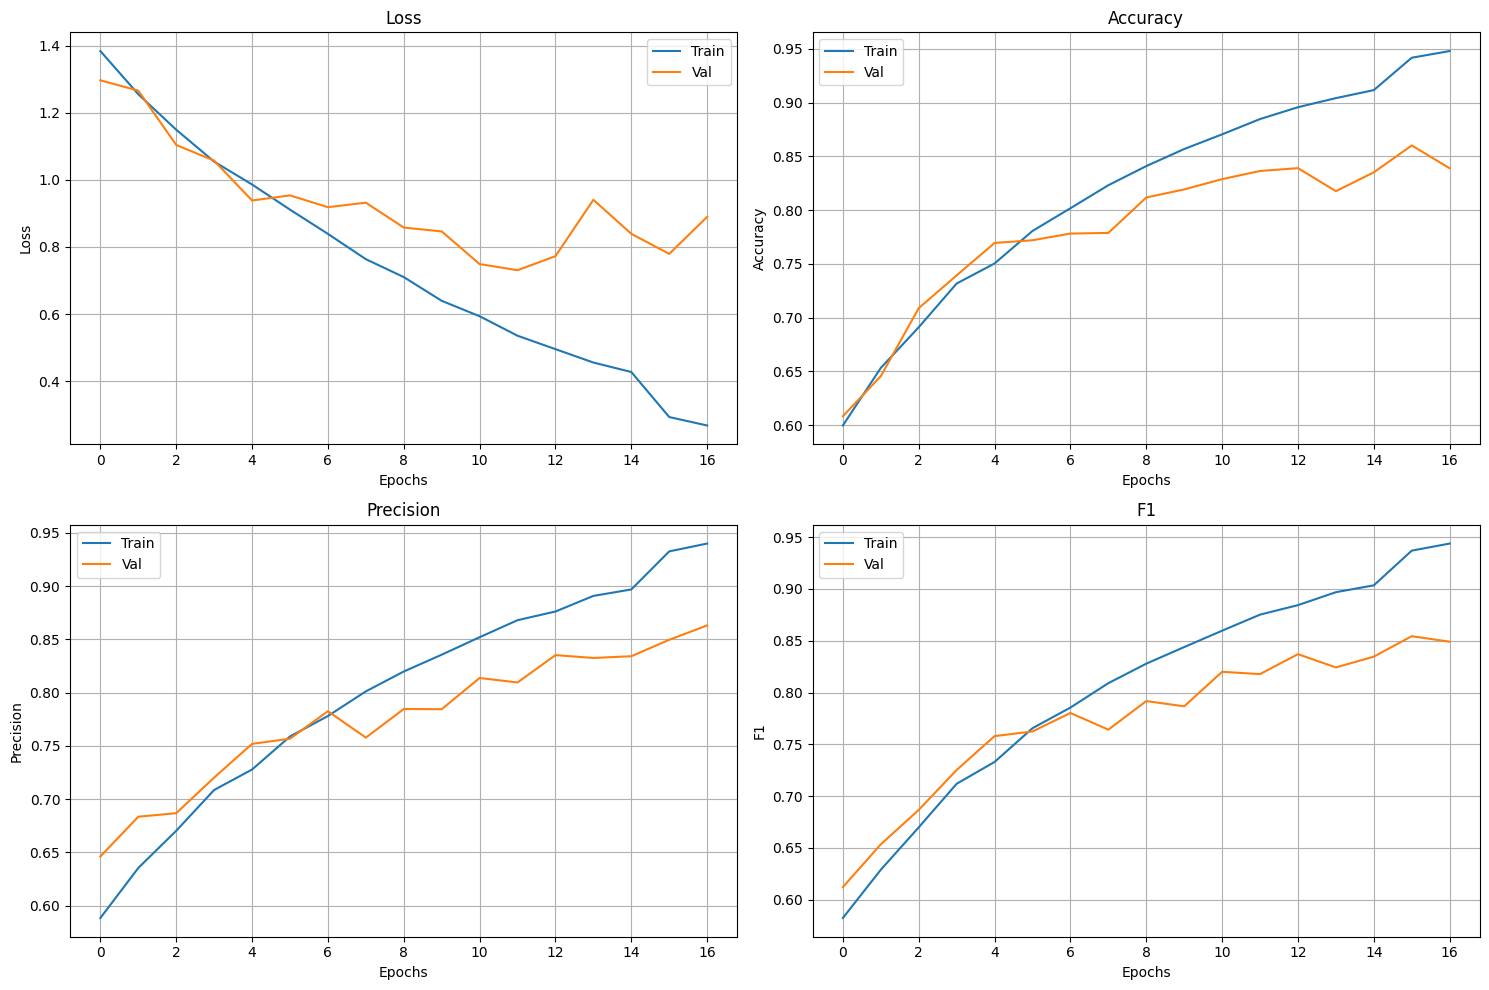

In [19]:
import torch
from torch import nn, optim
from torchmetrics import Accuracy, Precision, Recall, F1Score
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

class TrainerConfig:
    def __init__(self):
        self.num_classes = 2
        self.patience = 3
        self.min_delta = 1e-4
        self.plot_interval = 2
        self.max_grad_norm = 1.0
        self.early_stop_metric = 'loss'
        self.learning_rate = 3e-4
        self.weight_decay = 1e-5

class WeightedMultiClassLogLoss(nn.Module):
    def __init__(self, class_weights=None, device=None):
        """
        Initializes the Weighted Multi-Class Log Loss (WMCLL).
        
        Args:
            class_weights (torch.Tensor): A tensor of shape (num_classes,) containing weights for each class.
            device (torch.device): The device to perform the computation on.
        """
        super().__init__()
        self.device = device if device else torch.device('cpu')
        self.class_weights = class_weights.to(self.device) if class_weights is not None else None

    def forward(self, logits, targets):
        """
        Computes the Weighted Multi-Class Log Loss.
        
        Args:
            logits (torch.Tensor): Predicted logits of shape (batch_size, num_classes).
            targets (torch.Tensor): Ground truth of shape (batch_size, num_classes) as one-hot encoded.
        
        Returns:
            torch.Tensor: The computed weighted multi-class log loss.
        """
        logits, targets = logits.to(self.device), targets.to(self.device)
        
        if self.class_weights is not None:
            weights = self.class_weights.to(self.device)
        else:
            weights = torch.ones(logits.size(1), device=self.device)

        probs = torch.softmax(logits, dim=1)
        log_probs = torch.log(probs + 1e-8)
        weighted_log_loss = -torch.sum(weights * targets * log_probs, dim=1)
        loss = torch.mean(weighted_log_loss)

        return loss

class Trainer:
    def __init__(self, model, criterion, config=None):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.criterion = criterion
        self.config = config or TrainerConfig()
        
        # Initialize optimizer and scheduler
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay
        )
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=2,
            factor=0.5,
            min_lr=1e-6
        )
        
        # Initialize metrics with macro averaging
        self.metrics = {
            'accuracy': Accuracy(task='multiclass', num_classes=self.config.num_classes, average='macro').to(self.device),
            'precision': Precision(task='multiclass', num_classes=self.config.num_classes, average='macro').to(self.device),
            'recall': Recall(task='multiclass', num_classes=self.config.num_classes, average='macro').to(self.device),
            'f1': F1Score(task='multiclass', num_classes=self.config.num_classes, average='macro').to(self.device)
        }
        
        # Initialize training state
        self.best_model = None
        self.best_metric = float('inf') if self.config.early_stop_metric == 'loss' else float('-inf')
        self.history = {'train': [], 'val': []}
        self.epochs_without_improve = 0
        
        # Setup plotting
        self.fig, self.axes = plt.subplots(2, 2, figsize=(15, 10))
        plt.close()

    def reset_metrics(self):
        """Reset all metrics at the start of each epoch"""
        for metric in self.metrics.values():
            metric.reset()

    def validate(self, val_loader):
        """Validate the model on the validation set"""
        self.model.eval()
        total_loss = 0
        total_samples = 0
        self.reset_metrics()
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                batch_size = inputs.size(0)
                total_samples += batch_size
                
                outputs = self.model(inputs)
                one_hot = nn.functional.one_hot(labels, self.config.num_classes).float()
                total_loss += self.criterion(outputs, one_hot).item() * batch_size
                
                preds = outputs.argmax(1)
                for metric in self.metrics.values():
                    metric.update(preds, labels)
        
        metrics_dict = {
            'loss': total_loss / total_samples,
            'accuracy': self.metrics['accuracy'].compute().item(),
            'precision': self.metrics['precision'].compute().item(),
            'recall': self.metrics['recall'].compute().item(),
            'f1': self.metrics['f1'].compute().item()
        }
        
        return metrics_dict

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        total_samples = 0
        self.reset_metrics()
        
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            batch_size = inputs.size(0)
            total_samples += batch_size
            
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            one_hot = nn.functional.one_hot(labels, self.config.num_classes).float()
            loss = self.criterion(outputs, one_hot)
            
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
            self.optimizer.step()
            
            total_loss += loss.item() * batch_size
            preds = outputs.argmax(1)
            for metric in self.metrics.values():
                metric.update(preds, labels)
        
        metrics_dict = {
            'loss': total_loss / total_samples,
            'accuracy': self.metrics['accuracy'].compute().item(),
            'precision': self.metrics['precision'].compute().item(),
            'recall': self.metrics['recall'].compute().item(),
            'f1': self.metrics['f1'].compute().item()
        }
        
        return metrics_dict

    def train(self, train_loader, val_loader, epochs=10):
        """Main training loop"""
        print(f"Starting training on device: {self.device}")
        start_time = time.time()
        
        for epoch in range(epochs):
            epoch_start = time.time()
            
            # Training phase
            train_metrics = self.train_epoch(train_loader)
            
            # Validation phase
            val_metrics = self.validate(val_loader)
            
            # Update learning rate
            self.scheduler.step(val_metrics['loss'])
            
            # Store history
            self.history['train'].append(train_metrics)
            self.history['val'].append(val_metrics)
            
            # Print progress
            epoch_time = time.time() - epoch_start
            print(f"\nEpoch {epoch + 1}/{epochs} - Time: {epoch_time:.2f}s")
            print("Train:", " ".join(f"{k}: {v:.4f}" for k, v in train_metrics.items()))
            print("Val:", " ".join(f"{k}: {v:.4f}" for k, v in val_metrics.items()))
            
            # Check for improvement
            current = val_metrics[self.config.early_stop_metric]
            improved = (self.config.early_stop_metric == 'loss' and 
                       current < self.best_metric - self.config.min_delta) or \
                      (self.config.early_stop_metric != 'loss' and 
                       current > self.best_metric + self.config.min_delta)
            
            if improved:
                self.best_metric = current
                self.best_model = self.model.state_dict().copy()
                self.epochs_without_improve = 0
                print(f"Best {self.config.early_stop_metric}: {self.best_metric:.4f}")
            else:
                self.epochs_without_improve += 1
                if self.epochs_without_improve >= self.config.patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break
            
            # Plot if needed
            if (epoch + 1) % self.config.plot_interval == 0:
                self.plot_metrics(final=(epoch == epochs - 1))
            
            # Clear GPU memory
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        # Training completed
        total_time = time.time() - start_time
        print(f"\nTraining completed in {total_time:.2f}s")
        
        # Restore best model and plot final results
        self.model.load_state_dict(self.best_model)
        self.plot_metrics(final=True)
        return self.model

    def plot_metrics(self, final=False):
        """Plot training metrics"""
        metrics = ['loss', 'accuracy', 'precision', 'f1']
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
        
        for ax, metric in zip(axes, metrics):
            train_metric = [epoch[metric] for epoch in self.history['train']]
            val_metric = [epoch[metric] for epoch in self.history['val']]
            ax.plot(train_metric, label='Train')
            ax.plot(val_metric, label='Val')
            
            ax.set_title(f'{metric.capitalize()}')
            ax.set_xlabel('Epochs')
            ax.set_ylabel(metric.capitalize())
            ax.legend()
            ax.grid(True)
        
        plt.tight_layout()
        
        if final:
            plt.savefig('training_metrics.png')
            plt.show()
        else:
            plt.draw()
            plt.pause(0.1)
        plt.close(fig)

# Example usage:

# Create configuration
config = TrainerConfig()
config.num_classes = 2  # Adjust based on your task
config.patience = 5
config.learning_rate = 2e-4
config.weight_decay = 1e-5

criterion = WeightedMultiClassLogLoss(class_weights=class_weights_tensor)

# Create trainer
trainer = Trainer(model, criterion, config)

# Train the model
trained_model = trainer.train(train_loader, val_loader, epochs=20)

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from tqdm import tqdm

def evaluate_model(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    progress = tqdm(dataloader, desc="Evaluating")
    for inputs, labels in progress:
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

# Evaluate the trained model
evaluate_model(trained_model, test_loader, device)

Evaluating: 100%|██████████| 83/83 [01:33<00:00,  1.13s/it]

Accuracy: 0.8723
Precision: 0.8707
Recall: 0.8723
F1 Score: 0.8706
